In [2]:
# %load uoicorr_imports.py
%load_ext autoreload
%autoreload 2

import h5py

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from math import floor, ceil
# Script to add the entire project directory structure to the python path
import sys, os, pdb

# Hack to import pyuoi
parent_path, current_dir = os.path.split(os.path.abspath('.'))
while current_dir not in ['nse']:
	parent_path, current_dir = os.path.split(parent_path)
p = os.path.join(parent_path, current_dir)
# Add analysis
if p not in sys.path:
	sys.path.append(p)

# And standard list of subdirectories
if '%s\\pyuoi' % p not in sys.path:
	sys.path.append('%s\\pyuoi' % p)

from pyuoi.linear_model.lasso import UoI_Lasso
from pyuoi.linear_model.elasticnet import UoI_ElasticNet

In [3]:
from postprocess import postprocess_file

In [4]:
en = postprocess_file('test.h5', 'job0_params2')

OSError: Unable to open file (unable to open file: name = 'test.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [10]:
en02 = en 

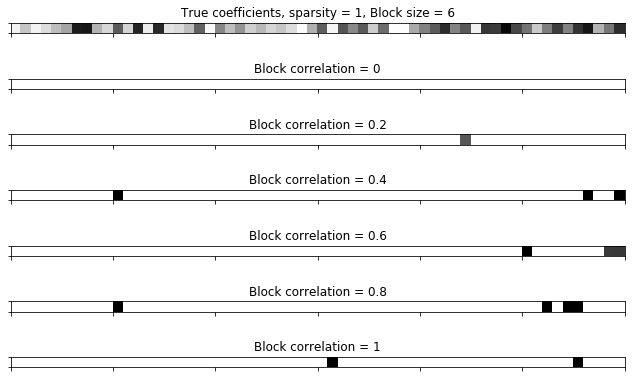

In [11]:
fig, ax = plt.subplots(7, 1, figsize=(11, 7))
# True beta
ax[0].set_aspect('equal')
ax[0].pcolor(en02.iloc[0].beta[0, :, np.newaxis].T, cmap='Greys', vmin = 0, vmax = 10)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_title('True coefficients, sparsity = 1, Block size = 6')

ax[1].set_aspect('equal')
ax[1].pcolor(en02.iloc[0].beta_hats[0, :, np.newaxis].T, cmap = 'Greys', vmin = 0, vmax = 10)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title('Block correlation = 0')

ax[2].set_aspect('equal')
ax[2].pcolor(en02.iloc[1].beta_hats[0, :, np.newaxis].T, cmap = 'Greys', vmin = 0, vmax = 10)
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_title('Block correlation = 0.2')

ax[3].set_aspect('equal')
ax[3].pcolor(en02.iloc[2].beta_hats[0, :, np.newaxis].T, cmap = 'Greys', vmin = 0, vmax = 10)
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])
ax[3].set_title('Block correlation = 0.4')

ax[4].set_aspect('equal')
ax[4].pcolor(en02.iloc[3].beta_hats[0, :, np.newaxis].T, cmap = 'Greys', vmin = 0, vmax = 10)
ax[4].set_xticklabels([])
ax[4].set_yticklabels([])
ax[4].set_title('Block correlation = 0.6')

ax[5].set_aspect('equal')
ax[5].pcolor(en02.iloc[4].beta_hats[0, :, np.newaxis].T, cmap = 'Greys', vmin = 0, vmax = 10)
ax[5].set_xticklabels([])
ax[5].set_yticklabels([])
ax[5].set_title('Block correlation = 0.8')

ax[6].set_aspect('equal')
ax[6].pcolor(en02.iloc[5].beta_hats[0, :, np.newaxis].T, cmap = 'Greys', vmin = 0, vmax = 10)
ax[6].set_xticklabels([])
ax[6].set_yticklabels([])
ax[6].set_title('Block correlation = 1')

plt.savefig('selection_profile.png')

### Can we get ordinary cross-validated LASSO to work?

In [2]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

In [14]:
%autoreload

In [3]:
from utils import gen_data, block_covariance

In [29]:
sigma = block_covariance(correlation = 0)
X, X_test, y, y_test, beta = gen_data(sparsity = 1, covariance = sigma, kappa = 0.1)

In [5]:
lcv = LassoCV(normalize = True, cv = 10)
lcv.fit(X, y.ravel())
print(r2_score(y_test.ravel(), np.dot(X_test, lcv.coef_)))

0.9121950241041663


### Contrast directly with UoI_Lasso

In [7]:
uoi = UoI_Lasso(
    normalize=True,
    n_boots_sel=48,
    n_boots_est=48,
    estimation_score='r2')
uoi.fit(X, y.ravel())
print(r2_score(y_test.ravel(), np.dot(X_test, uoi.coef_)))

0.9120832251194286


In [30]:
uoi = UoI_ElasticNet(
    normalize=True,
    n_boots_sel=48,
    n_boots_est=48,
    estimation_score='r2')
uoi.fit(X, y.ravel())
print(r2_score(y_test.ravel(), np.dot(X_test, uoi.coef_)))

0.866794168286299


Text(0.5, 1.0, 'UoI LASSO estimate')

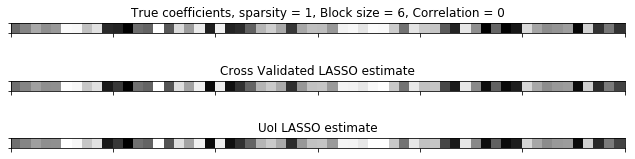

In [11]:
# Feature selection looks normal
fig, ax = plt.subplots(3, 1, figsize=(11, 3))
# True beta
ax[0].set_aspect('equal')
ax[0].pcolor(beta.T, cmap='Greys', vmin = 0, vmax = 10)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_title('True coefficients, sparsity = 1, Block size = 6, Correlation = 0')

ax[1].set_aspect('equal')
ax[1].pcolor(lcv.coef_[:, np.newaxis].T, cmap = 'Greys', vmin = 0, vmax = 10)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title('Cross Validated LASSO estimate')

ax[2].set_aspect('equal')
ax[2].pcolor(uoi.coef_[:, np.newaxis].T, cmap = 'Greys', vmin = 0, vmax = 10)
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_title('UoI LASSO estimate')

### The issue lies with the usage of BIC/AIC/AICc as the model estimation score. Specifically, model estimation seems to fail catastrophically as we reduce the n/p ratio. Let's see how fit performance varies:

In [6]:
n_features = 60
n_samples = 60 * np.arange(2, 5)

r2_scores = np.zeros(n_samples.size)
BIC_scores = np.zeros(n_samples.size)
AIC_scores = np.zeros(n_samples.size)
AICc_scores = np.zeros(n_samples.size)

# Collect final model coefficients and also record model supports prior to estimation
coefficients = np.zeros((n_features, n_samples.size))
supports = []
candidate_scores = []
estimates = []

for idx, ns in enumerate(n_samples):
    print(idx)
    sigma = block_covariance(correlation = 0)
    X, X_test, y, y_test, beta = gen_data(n_samples = ns, n_features = n_features, 
                              sparsity = 1, covariance = sigma, kappa = 0.1)
#     uoi_r2 = UoI_Lasso(
#         normalize=True,
#         n_boots_sel=48,
#         n_boots_est=48,
#         estimation_score='r2')
#     uoi_r2.fit(X, y.ravel())
    uoi_BIC = UoI_Lasso(
        normalize=True,
        n_boots_sel=48,
        n_boots_est=48,
        estimation_score='BIC')
    uoi_BIC.fit(X, y.ravel())

    coefficients[:, idx] = uoi_BIC.coef_
    supports.append(uoi_BIC.supports_)
    candidate_scores.append(uoi_BIC.scores_)
    estimates.append(uoi_BIC.estimates_)
#     uoi_AIC = UoI_Lasso(
#         normalize=True,
#         n_boots_sel=48,
#         n_boots_est=48,
#         estimation_score='AIC')
#     uoi_AIC.fit(X, y.ravel())
#     uoi_AICc = UoI_Lasso(
#         normalize=True,
#         n_boots_sel=48,
#         n_boots_est=48,
#         estimation_score='AICc')
#     try:
#         uoi_AICc.fit(X, y.ravel())
#     except:
#         continue
#     r2_scores[idx] = r2_score(y_test.ravel(), np.dot(X_test, uoi_r2.coef_))
#     BIC_scores[idx] = r2_score(y_test.ravel(), np.dot(X_test, uoi_BIC.coef_))
#     AIC_scores[idx] = r2_score(y_test.ravel(), np.dot(X_test, uoi_AIC.coef_))
    BIC_scores[idx] = r2_score(y_test.ravel(), np.dot(X_test, uoi_BIC.coef_))


0
1
2


(0, 1)

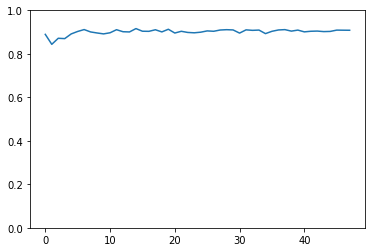

In [24]:
plt.plot(r2_scores)
plt.ylim([0, 1])

(0, 1)

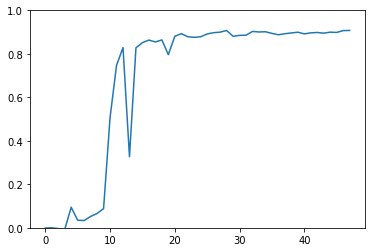

In [31]:
plt.plot(BIC_scores)
plt.ylim([0, 1])

(0, 1)

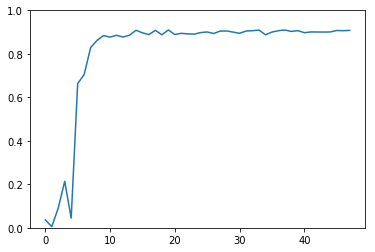

In [26]:
plt.plot(AIC_scores)
plt.ylim([0, 1])

### It is therefore clear that the BIC and AIC scores cause really poor model selection in the case when the number of samples is not significantly greater than the number of data points. This also explains the observation that the performance recovers in highly sparse scenarios - the number of features has decreased sufficiently. To do - check whether the concommitant increase in performance in the highly correlated regime is similarly due to selection of a smaller number of features. 

### Other to do - find the performance of AICc 

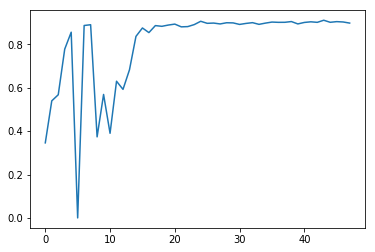

In [6]:
plt.plot(AICc_scores)

In [9]:
uoi_AICc.supports_.shape

(23, 60)

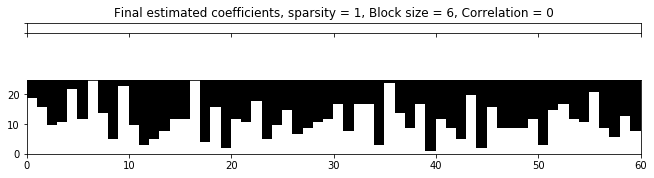

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(11, 3))

# Plot candidate model supports vs. final model coefficients
# True beta
ax[0].set_aspect('equal')
ax[0].pcolor(uoi_BIC.coef_[:, np.newaxis].T, cmap='Greys', vmin = 0, vmax = 10)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_title('Final estimated coefficients, sparsity = 1, Block size = 6, Correlation = 0')

ax[1].pcolor(uoi_BIC.supports_ * 1, cmap = 'Greys', vmin = 0, vmax = 1)

In [35]:
candidate_scores[2].shape

(48, 22)

In [39]:
np.argmax(candidate_scores[2], axis = 1)

array([0, 1, 1, 0, 1, 3, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 2, 0, 2,
       2, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 0, 0, 3, 1, 0, 1, 0,
       0, 0, 1, 4], dtype=int64)

In [10]:
uoi_BIC.rp_max_idx_

array([2, 0, 0, 1, 2, 0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0,
       1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2,
       0, 1, 0, 0], dtype=int64)

In [15]:
best_estimates = uoi_BIC.estimates_[np.arange(48), uoi_BIC.rp_max_idx_, :]

In [16]:
best_estimates.shape

(48, 60)

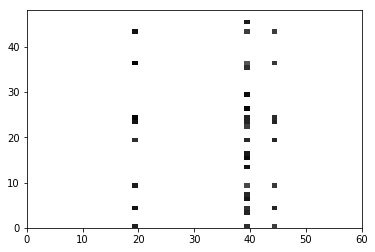

In [18]:
plt.pcolor(best_estimates, cmap='Greys')

In [39]:
sigma = block_covariance(correlation = 0)
X, X_test, y, y_test, beta = gen_data(n_samples = 180, n_features = 60, 
                          sparsity = 1, covariance = sigma, kappa = 0.1)
uoi_BIC = UoI_Lasso(
    normalize=True,
    n_boots_sel=48,
    n_boots_est=48,
    estimation_score='BIC')
uoi_BIC.fit(X, y.ravel())

UoI_Lasso(comm=None, copy_X=True, eps=0.001, estimation_frac=0.9,
     estimation_score='BIC', fit_intercept=True, max_iter=None,
     n_boots_est=48, n_boots_sel=48, n_lambdas=48, normalize=True,
     random_state=None, selection_frac=0.9, stability_selection=1.0,
     warm_start=None)

In [35]:
# What is the R^2 vs. the BIC performance of the different model supports on the first bootstrap sample

In [40]:
r2_scores = np.zeros(uoi_BIC.estimates_.shape[1])
for idx, estimate in enumerate(uoi_BIC.estimates_[0, :, :]):
    r2_scores[idx] = r2_score(y_test.ravel(), np.dot(X_test, estimate))        

In [41]:
r2_scores

array([-3.78720291e-02, -2.30950419e+01, -3.60860842e+01, -5.36141485e+01,
       -6.80741289e+01, -8.95049689e+01, -8.62322061e+01, -9.85173944e+01,
       -1.07391487e+02, -1.19299461e+02, -1.16943433e+02, -1.33609700e+02,
       -1.31620709e+02, -1.27901004e+02, -1.44963680e+02, -1.45549301e+02,
       -1.47293938e+02, -1.45051974e+02, -1.46513089e+02, -1.46421244e+02,
       -1.47213254e+02, -1.47968112e+02, -1.50822503e+02, -1.52683560e+02,
       -1.54060530e+02, -1.54705892e+02, -1.54378361e+02, -1.53779471e+02])

In [42]:
uoi_BIC.scores_[0, :]

array([-141.92802, -146.65579, -147.9324 , -157.10867, -153.58475,
       -160.44626, -166.84932, -177.23518, -182.38249, -199.5927 ,
       -199.0019 , -204.45952, -205.8383 , -210.13614, -216.04045,
       -219.79759, -224.10968, -228.02113, -233.5026 , -235.58446,
       -238.6809 , -240.59793, -242.9813 , -246.69688, -250.05092,
       -252.96416, -256.23746, -259.5538 ], dtype=float32)

array([ 64.97303 ,   0.      ,   0.      , 154.00899 ,  47.70129 ,
        45.583103, 116.841675, 142.99446 , 109.45308 , 105.91328 ,
       119.26796 ,  39.52747 ,  98.46169 ,  76.96301 ,  76.49258 ,
       -31.664505,  42.11186 ,  33.95235 , 143.96153 ,  56.98988 ,
        40.722126,  88.18301 ,  17.577656, 112.848   ,  89.93637 ,
        57.988003,  41.200745,  85.79469 ,  10.022643,  -5.783868,
         0.      ,  61.367264,  50.490757,  65.85593 ,  75.86739 ,
        56.54969 ,  30.242613,  19.89349 , 143.08684 ,  17.633558,
       146.45721 ,  91.75292 ,  40.670242,  58.954872,  47.995193,
        82.91099 ,  60.978558, 135.29039 ,  18.234137,  15.130453,
        55.82056 ,  83.62071 ,  92.71832 ,  -5.270291,  95.13351 ,
        67.80934 , 118.9774  , 100.342125,  68.39378 ,  21.32898 ],
      dtype=float32)

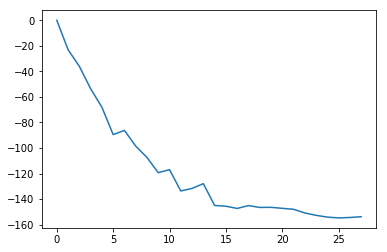

In [45]:
plt.plot(r2_scores)

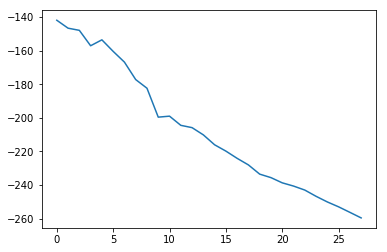

In [47]:
plt.plot(uoi_BIC.scores_[0, :])

In [ ]:
# Even in the case when model supports are non-sparse, the estimation seems to fail miserably. Let's compare with using
# r2 estimation

In [48]:
uoi_r2 = UoI_Lasso(
    normalize=True,
    n_boots_sel=48,
    n_boots_est=48,
    estimation_score='r2')
uoi_r2.fit(X, y.ravel())

UoI_Lasso(comm=None, copy_X=True, eps=0.001, estimation_frac=0.9,
     estimation_score='r2', fit_intercept=True, max_iter=None,
     n_boots_est=48, n_boots_sel=48, n_lambdas=48, normalize=True,
     random_state=None, selection_frac=0.9, stability_selection=1.0,
     warm_start=None)

In [54]:
# Verify good performance of the r^2 model: 
print(r2_score(y_test.ravel(), np.dot(X_test, uoi_r2.coef_)))

0.8708560484239333


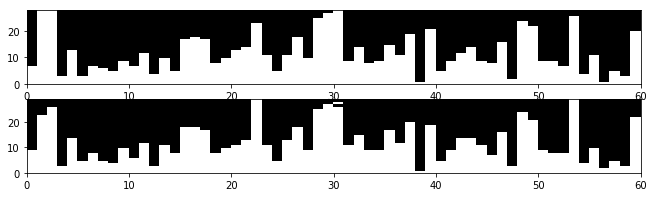

In [52]:
# Supports are similar (as expected)
fig, ax = plt.subplots(2, 1, figsize=(11, 3))
ax[0].pcolor(uoi_BIC.supports_ *1, cmap = 'Greys', vmin = 0, vmax = 1)
ax[1].pcolor(uoi_r2.supports_ * 1, cmap = 'Greys', vmin = 0, vmax = 1)

In [63]:
# Performance of individual r^2 supports:
r2_r2_scores = np.zeros(uoi_r2.estimates_.shape[1])
for idx, estimate in enumerate(uoi_r2.estimates_[20, :, :]):
    r2_r2_scores[idx] = r2_score(y_test.ravel(), np.dot(X_test, estimate))        

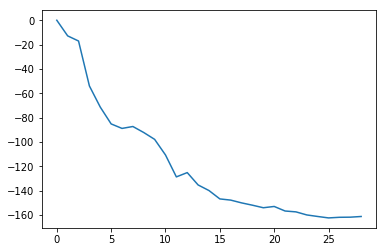

In [64]:
plt.plot(r2_r2_scores)

In [4]:
# What is the r^2 performance of the various model supports from uoi_BIC, and track the congruence/lack of congruence
# between the corresponding BIC score
sigma = block_covariance(correlation = 0)
X, X_test, y, y_test, beta = gen_data(n_samples = 180, n_features = 60, 
                          sparsity = 1, covariance = sigma, kappa = 0.1)
uoi_BIC = UoI_Lasso(
    normalize=True,
    n_boots_sel=48,
    n_boots_est=48,
    estimation_score='BIC')
uoi_BIC.fit(X, y.ravel())

UoI_Lasso(comm=None, copy_X=True, eps=0.001, estimation_frac=0.9,
     estimation_score='BIC', fit_intercept=True, max_iter=None,
     n_boots_est=48, n_boots_sel=48, n_lambdas=48, normalize=True,
     random_state=None, selection_frac=0.9, stability_selection=1.0,
     warm_start=None)

In [5]:
uoi_BIC.supports_.shape

(28, 60)

In [5]:
from sklearn.model_selection import train_test_split

In [15]:
# Do this over 48 bootstraps
n_bootstraps= 48

BIC_scores = np.zeros((n_bootstraps, uoi_BIC.supports_.shape[0]))
r2_scores = np.zeros((n_bootstraps, uoi_BIC.supports_.shape[0]))

for b in range(n_bootstraps):
    for idx in range(uoi_BIC.supports_.shape[0]):
        support = uoi_BIC.supports_[idx, :]
        # Analgously to the algorithm itself, sample a bootstrap of the training data and fit, and then calculate both
        # the r2_score and the BIC:
        Xb_train, Xb_test, yb_train, yb_test = train_test_split(X, y, test_size = 0.1)
        em = uoi_BIC.estimation_lm
        if np.any(support):
            em.fit(Xb_train[:, support], yb_train)
            yb_pred = em.predict(Xb_test[:, support])
        else:
            yb_pred = np.zeros(yb_test.size)
        # Calculate the BIC score
        BIC_scores[b, idx] = uoi_BIC.score_predictions(uoi_BIC.estimation_score, yb_test, yb_pred, support)
        # Calculate the R2 score
        r2_scores[b, idx] = r2_score(yb_test, yb_pred)

# Average over bootstraps
BIC_scores = np.mean(BIC_scores, 0)
r2_scores = np.mean(r2_scores, 0)

In [9]:
BIC_scores

array([-203.89804377, -141.97200826, -157.1050528 , -143.68825217,
       -153.59931534, -147.76046837, -166.40026067, -169.75741001,
       -175.63163514, -175.40324835, -186.73762477, -189.18611996,
       -188.33444117, -196.45919994, -194.17377673, -210.08620267,
       -214.34064547, -230.0412068 , -221.05010312, -240.5533047 ,
       -232.15789362, -236.11963408, -230.02733983, -233.51287527,
       -253.49339027, -263.03625037, -255.41998689, -270.19201222])

In [10]:
r2_scores

array([-0.01881443, -0.03141317, -0.17634935,  0.3714707 ,  0.64029344,
        0.75640443,  0.40142529,  0.64612956,  0.61155398,  0.75593662,
        0.79494274,  0.65040285,  0.88376858,  0.79269855,  0.85084005,
        0.87762458,  0.84732614,  0.70234455,  0.89189999,  0.86982899,
        0.90009827,  0.88455753,  0.86246833,  0.89500261,  0.84975285,
        0.79134191,  0.7598482 ,  0.8074793 ])

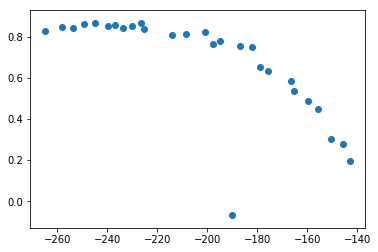

In [16]:
plt.scatter(BIC_scores, r2_scores)

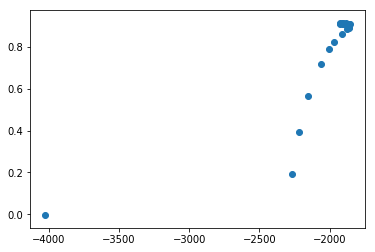

In [17]:
# How does this correspondence change in the regime when the BIC seems to be performing good model selection

sigma = block_covariance(correlation = 0)
X, X_test, y, y_test, beta = gen_data(n_samples = 3000, n_features = 60, 
                          sparsity = 1, covariance = sigma, kappa = 0.1)
uoi_BIC = UoI_Lasso(
    normalize=True,
    n_boots_sel=48,
    n_boots_est=48,
    estimation_score='BIC')
uoi_BIC.fit(X, y.ravel())

# Do this over 48 bootstraps
n_bootstraps= 48

BIC_scores = np.zeros((n_bootstraps, uoi_BIC.supports_.shape[0]))
r2_scores = np.zeros((n_bootstraps, uoi_BIC.supports_.shape[0]))

for b in range(n_bootstraps):
    for idx in range(uoi_BIC.supports_.shape[0]):
        support = uoi_BIC.supports_[idx, :]
        # Analgously to the algorithm itself, sample a bootstrap of the training data and fit, and then calculate both
        # the r2_score and the BIC:
        Xb_train, Xb_test, yb_train, yb_test = train_test_split(X, y, test_size = 0.1)
        em = uoi_BIC.estimation_lm
        if np.any(support):
            em.fit(Xb_train[:, support], yb_train)
            yb_pred = em.predict(Xb_test[:, support])
        else:
            yb_pred = np.zeros(yb_test.size)
        # Calculate the BIC score
        BIC_scores[b, idx] = uoi_BIC.score_predictions(uoi_BIC.estimation_score, yb_test, yb_pred, support)
        # Calculate the R2 score
        r2_scores[b, idx] = r2_score(yb_test, yb_pred)

# Average over bootstraps
BIC_scores = np.mean(BIC_scores, 0)
r2_scores = np.mean(r2_scores, 0)

plt.scatter(BIC_scores, r2_scores)

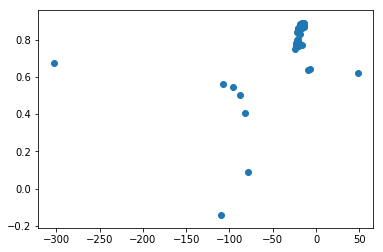

In [26]:
# What about when there is sparsity?

sigma = block_covariance(correlation = 0.4)
X, X_test, y, y_test, beta = gen_data(n_samples = 120, n_features = 60, 
                          sparsity = 0.4, covariance = sigma, kappa = 0.1)
uoi_BIC = UoI_ElasticNet(
    normalize=True,
    n_boots_sel=48,
    n_boots_est=48,
    estimation_score='AICc')
uoi_BIC.fit(X, y.ravel())

# Do this over 48 bootstraps
n_bootstraps= 48

BIC_scores = np.zeros((n_bootstraps, uoi_BIC.supports_.shape[0]))
r2_scores = np.zeros((n_bootstraps, uoi_BIC.supports_.shape[0]))

for b in range(n_bootstraps):
    for idx in range(uoi_BIC.supports_.shape[0]):
        support = uoi_BIC.supports_[idx, :]
        # Analgously to the algorithm itself, sample a bootstrap of the training data and fit, and then calculate both
        # the r2_score and the BIC:
        Xb_train, Xb_test, yb_train, yb_test = train_test_split(X, y, test_size = 0.1)
        em = uoi_BIC.estimation_lm
        if np.any(support):
            em.fit(Xb_train[:, support], yb_train)
            yb_pred = em.predict(Xb_test[:, support])
        else:
            yb_pred = np.zeros(yb_test.size)
        # Calculate the BIC score
        BIC_scores[b, idx] = uoi_BIC.score_predictions(uoi_BIC.estimation_score, yb_test, yb_pred, support)
        # Calculate the R2 score
        r2_scores[b, idx] = r2_score(yb_test, yb_pred)

# Average over bootstraps
BIC_scores = np.mean(BIC_scores, 0)
r2_scores = np.mean(r2_scores, 0)

plt.scatter(BIC_scores, r2_scores)

In [27]:
def estimation_performance(n_bootstraps, uoi_model):

    est_scores = np.zeros((n_bootstraps, uoi_model.supports_.shape[0]))
    r2_scores = np.zeros((n_bootstraps, uoi_model.supports_.shape[0]))    

    for b in range(n_bootstraps):
        for idx in range(uoi_model.supports_.shape[0]):
            support = uoi_model.supports_[idx, :]
            # Analgously to the algorithm itself, sample a bootstrap of the training data and fit, and then calculate both
            # the r2_score and the BIC:
            Xb_train, Xb_test, yb_train, yb_test = train_test_split(X, y, test_size = 0.1)
            em = uoi_model.estimation_lm
            if np.any(support):
                em.fit(Xb_train[:, support], yb_train)
                yb_pred = em.predict(Xb_test[:, support])
            else:
                yb_pred = np.zeros(yb_test.size)
            # Calculate the BIC score
            est_scores[b, idx] = uoi_model.score_predictions(uoi_model.estimation_score, yb_test, yb_pred, support)
            # Calculate the R2 score
            r2_scores[b, idx] = r2_score(yb_test, yb_pred)

    # Average over bootstraps
    est_scores = np.mean(est_scores, 0)
    r2_scores = np.mean(r2_scores, 0)
    
    return est_scores, r2_scores

In [35]:
import time
from sklearn.metrics import r2_score
from utils import gen_data, gen_beta, block_covariance

# let's fit models across a 2D parameter space of sample size and sparsity. 
n_features = 60
sparsity = np.linspace(0.2, 1, 10)
n_samples = n_features * np.linspace(1, 50, 10).astype(int)
reps = 5
n_boots = 48
# Do two things on each repetition
# 1) Generate data and fit model using the various estimation scores
# 2) Take the resulting model and compare the performance of the various estimation scores to the r_2 score over 48 bootstraps

# Record scores of model performance on test data
r2_scores = np.zeros((reps, sparsity.size, n_samples.size))
BIC_scores = np.zeros(r2_scores.shape)
AIC_scores = np.zeros(r2_scores.shape)
AICc_scores = np.zeros(r2_scores.shape)

# Record scores on bootstrapped data
b_BIC_scores = []
b_BIC_scores_r2 = []

b_AIC_scores = []
b_AIC_scores_r2 = []

b_AICc_scores = []
b_AICc_scores_r2 = []

for ns_idx, ns in enumerate(n_samples):
    for sidx, s in enumerate(sparsity):
        # Generate consistent set of model parameters across repititions
        betas = gen_beta(sparsity = s, betadist = 'uniform')
        for rep in range(reps):
            # Generate data
            start_time = time.time()
            X, X_test, y, y_test = gen_data(n_samples = ns, covariance = block_covariance(correlation = 0.25), beta = betas)
            
            # Fit using the various estimation scores
            uoi_r2 = UoI_ElasticNet(
            normalize=True,
            n_boots_sel=48,
            n_boots_est=48,
            estimation_score='r2',
            warm_start = False)
            
            uoi_r2.fit(X, y.ravel())
            
            uoi_BIC = UoI_ElasticNet(
            normalize=True,
            n_boots_sel=48,
            n_boots_est=48,
            estimation_score='BIC',
            warm_start = False)
            
            uoi_BIC.fit(X, y.ravel())

            uoi_AIC = UoI_ElasticNet(
            normalize=True,
            n_boots_sel=48,
            n_boots_est=48,
            estimation_score='AIC',
            warm_start = False)
            
            uoi_AIC.fit(X, y.ravel())

            # Fit using the various estimation scores
            uoi_AICc = UoI_ElasticNet(
            normalize=True,
            n_boots_sel=48,
            n_boots_est=48,
            estimation_score='AICc',
            warm_start = False)
            
            try:
                uoi_AICc.fit(X, y.ravel())
                AICc_scores[rep, sidx, ns_idx] = r2_score(y_test, uoi_AICc.predict(X_test))
                AICc, r2 = estimation_performance(n_boots, uoi_AICc)
                b_AICc_scores.append(AICc)
                b_AICc_scores_r2.append(r2)
            except:
                b_AICc_scores.append(None)
                b_AICc_scores_r2.append(None)
                
            # Record nominal scores
            r2_scores[rep, sidx, ns_idx] = r2_score(y_test, uoi_r2.predict(X_test))
            BIC_scores[rep, sidx, ns_idx] = r2_score(y_test, uoi_BIC.predict(X_test))
            AIC_scores[rep, sidx, ns_idx] = r2_score(y_test, uoi_AIC.predict(X_test))
            
            # Record bootstrap scores
        
            BIC, r2 = estimation_performance(n_boots, uoi_BIC)
            b_BIC_scores.append(BIC)
            b_BIC_scores_r2.append(r2)

            AIC, r2 = estimation_performance(n_boots, uoi_AIC)
            b_AIC_scores.append(AIC)
            b_AIC_scores_r2.append(r2)

            print(time.time() - start_time)

11.751569032669067
10.62159013748169
12.187402725219727
8.926125764846802
11.305760145187378
9.076723098754883
10.244599103927612
9.430775880813599
9.352983713150024
11.315733194351196
11.646848440170288
9.788818359375
9.239287853240967
9.556440114974976
11.269855976104736
12.519514560699463
11.672779083251953
9.67312741279602
11.541131496429443
8.964024066925049
11.557088375091553
10.084028959274292
11.67676830291748
11.793456315994263
11.334683656692505
9.71302080154419
11.754560947418213
12.206351518630981
11.636875629425049
9.41780972480774
12.059744119644165
9.670135498046875
11.652832746505737
12.665124416351318
9.475656032562256
9.63223671913147
12.027829885482788
9.680108547210693
12.62622857093811
11.918123245239258
9.618274688720703
12.392853021621704
9.822726964950562
9.274194717407227
9.769869089126587
12.630217790603638
12.058747053146362
11.707685708999634
12.132548809051514
9.425789594650269
11.640864133834839
13.08799433708191
11.683749437332153
10.694396018981934
11.27

46.34703707695007
45.7616024017334
53.718708992004395
50.72133731842041
45.397576332092285
36.784613609313965
37.80789756774902
40.58245515823364
37.81685209274292
43.4368212223053
84.03988099098206
66.62437629699707
62.576627254486084
53.465996503829956
64.85054588317871
66.36948251724243
69.26728343963623
68.66335463523865
66.60368227958679
65.37115383148193
57.91114330291748
61.77078318595886
68.18762016296387
73.06657099723816
66.42433643341064
66.84620809555054
65.83391547203064
68.62794780731201
83.74124145507812
74.35723400115967
60.309248208999634
59.026124715805054
64.73186302185059
58.86954402923584
66.19395136833191
64.15946078300476
54.391595125198364
62.02261734008789
60.74683165550232
70.32699084281921
52.531296491622925
55.86978602409363
54.35885214805603
51.18822717666626
54.63389849662781
55.35750722885132
53.39925169944763
62.23310446739197
60.86092472076416
59.591702461242676
60.279858112335205
59.34764814376831
63.67601680755615
58.27618980407715
55.103615045547485


In [40]:
# Average over reps:
r2_scores_avg = np.mean(r2_scores, 0)
BIC_scores_avg = np.mean(BIC_scores, 0)
AIC_scores_avg = np.mean(AIC_scores, 0)
AICc_scores_avg = np.mean(AICc_scores, 0)

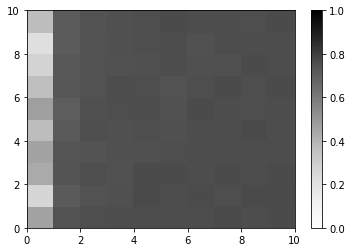

In [43]:
plt.pcolor(r2_scores_avg, cmap = 'Greys', vmin = 0, vmax = 1)
plt.colorbar()

In [46]:
r2_scores_avg[1, 0]

0.2629721509533288

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

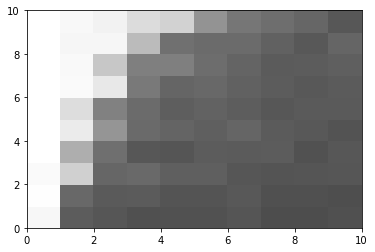

In [48]:
plt.pcolor(BIC_scores_avg, cmap = 'Greys', vmin = 0, vmax = 1)
plt.colorbar

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

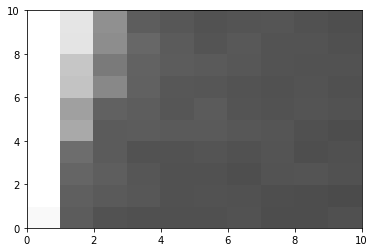

In [49]:
plt.pcolor(AIC_scores_avg, cmap = 'Greys', vmin = 0, vmax = 1)
plt.colorbar

In [54]:
# For AICc, need to first remove zeros from the averaging process
AICc_nan = AICc_scores.copy()
AICc_nan[AICc_nan == 0] = np.nan
AICc_nan_avg = np.nanmean(AICc_nan, 0)

C:\Users\akumar\Anaconda3\envs\nse\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [55]:
AICc_nan_avg.shape

(10, 10)

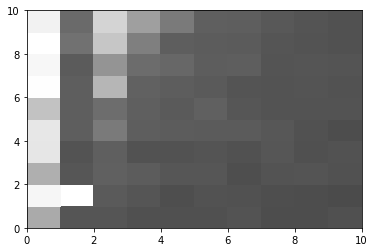

In [56]:
plt.pcolor(AICc_nan_avg, cmap = 'Greys', vmin = 0, vmax = 1)

In [36]:
from scipy.io import savemat

In [57]:
savemat('SelectionIsolationData1.mat', {'r2_scores': r2_scores, 'BIC_scores': BIC_scores, 'AIC_scores': AIC_scores, 'AICc_scores': AICc_scores})